In [38]:
from qiskit import QuantumCircuit
from qiskit import BasicAer
from qiskit import IBMQ
from qiskit import execute
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

### The Three-Qubit Quantum Search

Grover's quantum search algorithm provides a polynomial speed-up to the best-known classical algorithm for unstructured databases.

Classically, one can find a desired item out of $N$ items after $N/2$ tries on average. Grover's search allows one to find the item after $\sqrt{N}$ tries.

For an unstructured database of $4$ items, both search algorithms are of equal efficiency.
To prove that Grover's quantum search is more efficient that the classical method, a database of $5$ or more items is required.

We test for the Grover search's efficiency using IBM Qiskit's QASM simulator. Here, we label three qubits as our database.
Three qubits, when placed in uniform superposition, holds enough information for $2^3 = 8$ unstructured items. 
The expectation is that after $\sqrt{8} = 2\sqrt{2} \approx 3$ times, a desired item will be found.

### Initialization Circuit

To enable Grover's search on three qubits, we need two extra qubits to help perform the computation. This doesn't add any more information to the database.

Here, we construct a circuit of five qubits and three classical bits (to hold the measurement of our three-qubit database search).

In [39]:
qc_init = QuantumCircuit(5,3)

state = Statevector.from_instruction(qc_init)
state.draw(output = 'latex')

<IPython.core.display.Latex object>

$$
|00000\rangle
$$ (initial state)

To encode the unstructured database, we apply the Hadamard to the first three qubits.

In [40]:
qc_init.h(range(3))

state = Statevector.from_instruction(qc_init)
state.draw(output = 'latex')

<IPython.core.display.Latex object>

$$
|00+++ \rangle
$$ (three hadamards)

The algorithm requires a $|-\rangle$ state target to mark the desired item in the database. So we apply an X gate, then Hadamard, on the last qubit.

In [41]:
qc_init.x(4)
qc_init.h(4)

state = Statevector.from_instruction(qc_init)
state.draw(output = 'latex')

<IPython.core.display.Latex object>

$$
|-0+++\rangle
$$ (fourth hadamard)

In [42]:
qc_init.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     └───┘     
q_3: ──────────
     ┌───┐┌───┐
q_4: ┤ X ├┤ H ├
     └───┘└───┘
c: 3/══════════

### Oracle Circuit
We decide that the desired item will be the one with index $6$, or state $|110\rangle$. We now encode an oracle that can mark
$|110\rangle$ as the desired item.

If we let $U = I - 2|110\rangle\langle110|$ represent the oracle, then:

$$
\begin{align*}
U|110\rangle &= \Big(I - 2|110\rangle\langle110|\Big)|110\rangle \\
&= I|110\rangle - 2|110\rangle\langle110|\Big(|110\rangle\Big) \\
&= |110\rangle - 2|110\rangle \Big(\langle110|110\rangle\Big) \\
&= |110\rangle - 2|110\rangle = -|110\rangle
\end{align*}
$$ (oracle)

All other states remain unaffected by this unitary. In terms of gates, we can encode this by applying an $X$ gate before and after a controlled NOT on the $|-\rangle$ state, where the $X$ is on the $i$-th qubit in our desired state where there's a zero.

$$
\begin{align*}

|-0+++\rangle =& \frac{1}{2} \Big( |0\rangle - |1\rangle\Big) |0\rangle \Big( |000\rangle + |001\rangle + |010\rangle + |011\rangle 
+ |100\rangle + |101\rangle + |110\rangle + 111\rangle \Big)  \\

\Big( I \otimes I \otimes I \otimes I \otimes X \Big) \rightarrow& 
\frac{1}{2} \Big( |0\rangle - |1\rangle\Big) |0\rangle \Big( |001\rangle + |000\rangle + |011\rangle + |010\rangle 
+ |101\rangle + |100\rangle + |111\rangle + 110\rangle \Big)  \\

C^3(X) \rightarrow& \frac{1}{2} \Big( |0\rangle - |1\rangle\Big) |0\rangle \Big( |001\rangle + |000\rangle + |011\rangle + |010\rangle 
+ |101\rangle + |100\rangle - |111\rangle + 110\rangle \Big)  \\

\Big( I \otimes I \otimes I \otimes I \otimes X \Big) \rightarrow& \frac{1}{2} \Big( |0\rangle - |1\rangle\Big) |0\rangle \Big( |000\rangle + |001\rangle + |010\rangle + |011\rangle 
+ |100\rangle + |101\rangle - |110\rangle + 111\rangle \Big) 

\end{align*}
$$ (oracle gates)

As shown above, the third qubit gets the symmetric $X$ gate because our desired state is $|110\rangle$. The effect of the  controlled NOT on the last $|-\rangle$ state is that the amplitude of $|110\rangle$ is flipped in sign.

In [43]:
# Note: this new circuit is in state |00000> but will be composed on, or continued from, the previous circuit in later code.
qc_orac = QuantumCircuit(5,3)

# We use the working qubit (the fifth qubit) as the target of the to set up the C^3(X) with first three qubits as the controls.
qc_orac.x(0)
qc_orac.ccx(0,1,3)
qc_orac.ccx(2,3,4)
qc_orac.ccx(0,1,3)
qc_orac.x(0) # The state is |000> + ... - |110> + |111>

qc_orac.draw()

┌───┐               ┌───┐
q_0: ┤ X ├──■─────────■──┤ X ├
     └───┘  │         │  └───┘
q_1: ───────■─────────■───────
            │         │       
q_2: ───────┼────■────┼───────
          ┌─┴─┐  │  ┌─┴─┐     
q_3: ─────┤ X ├──■──┤ X ├─────
          └───┘┌─┴─┐└───┘     
q_4: ──────────┤ X ├──────────
               └───┘          
c: 3/═════════════════════════

### Amplification Circuit

We continue to amplify the amplitude of the desired state. The unitary for this is known as $U = 2|µ\rangle\langle µ| - I$, which reflects the amplitude of the desired state about the mean probability across all states.

Since $|µ\rangle$ is the uniform superposition of all qubits, we can write $U$ as $U = H^{\otimes n} \Big(2|0\rangle\langle0| - I\Big) H^{\otimes n}$. 
The $2|0\rangle\langle0| - I$ unitary is similar to before but instead requires an $X$ gate applied to all qubits before and after a $C^2(X)$ on the last qubit. Between the $X$'s and the $C^2(X)$ we also apply $iI$ to the first bit, and $H$ to the last bit. This gives us:

$$
\begin{align*}

\Big(X \otimes X \otimes X\Big)\quad &|000\rangle \ &\rightarrow \qquad \qquad &\quad \ \ \ |111\rangle \\

\Big(iI \otimes I \otimes H\Big)\quad &|111\rangle \ &\rightarrow \qquad \qquad &\quad \ i|11-\rangle \\

C^2(X)\quad i&|11-\rangle \qquad \quad &\rightarrow \qquad \qquad &-i|11-\rangle \\

\Big(iI \otimes I \otimes H\Big) -i&|11-\rangle \ &\rightarrow \qquad \qquad &\quad \ \ \ |111\rangle \\

\Big(X \otimes X \otimes X\Big)\quad &|111\rangle \ &\rightarrow \qquad \qquad &\quad \ \ \ |000\rangle

\end{align*}
$$

<p style="text-align:center;">
<span style="color:red;">Interesting to note, whether or not you apply the XYZ gates to achieve complex Identity or to achieve Identity <b>doesn't matter</b>.</span>
</p>

The action of the unitary does nothing to the $|000\rangle$ state but for any other state $|\psi\rangle$, outputs $-|\psi\rangle$, thus flipping the state about its average amplitude, and amplifying the marked state from before.

Below we encode the unitary for the amplification

In [44]:
# Note: this new circuit is in state |00000> but will be composed on, or continued from, the previous circuit in later code.
qc_diff = QuantumCircuit(5,3)

qc_diff.h(range(3)) # Hadamard on all qubits
qc_diff.x(range(3)) # X gate on all qubits
# qc_diff.x(0) # part of iI
# qc_diff.y(0) # part of iI
# qc_diff.z(0) # part of iI
qc_diff.h(2)
qc_diff.ccx(0,1,2)
qc_diff.h(2)
# qc_diff.x(0) # part of iI
# qc_diff.y(0) # part of iI
# qc_diff.z(0) # part of iI
qc_diff.x(range(3)) # X gate on all qubits
qc_diff.h(range(3)) # Hadamard on all qubits

# The state circuit after U = 2|µ><µ| - I
qc_diff.draw()

┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘
q_3: ───────────────────────────────────
                                        
q_4: ───────────────────────────────────
                                        
c: 3/═══════════════════════════════════

### Putting it altogether into one circuit

The number of "tries" in the Grover search is the number of repeated Oracle and Amplification circuits, which should follow $\sqrt{N} \approx 3$.
We can test the search after one, two, and three tries to verify this is the case.

In [45]:
# Circuits for each case on the number of tries
qc_1 = QuantumCircuit(5,3)
qc_2 = QuantumCircuit(5,3)
qc_3 = QuantumCircuit(5,3)

In [46]:
# Composing the circuits for one try
# Initialization
qc_1 = qc_1.compose(qc_init)
# Oracle and amplification
qc_1 = qc_1.compose(qc_orac)
qc_1 = qc_1.compose(qc_diff)
# Measurement on the database state
qc_1.measure(range(3),range(3))

qc_1.draw()

┌───┐┌───┐               ┌───┐┌───┐┌───┐     ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├┤ X ├──■─────────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────┤M├──────
     ├───┤└───┘  │         │  ├───┤├───┤└───┘  │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├───────■─────────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤       │         │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├───────┼────■────┼──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘     ┌─┴─┐  │  ┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
q_3: ──────────┤ X ├──■──┤ X ├────────────────────────────────────╫──╫──╫─
     ┌───┐┌───┐└───┘┌─┴─┐└───┘                                    ║  ║  ║ 
q_4: ┤ X ├┤ H ├─────┤ X ├─────────────────────────────────────────╫──╫──╫─
     └───┘└───┘     └───┘                                         ║  ║  ║ 
c: 3/═════════════════════════════════════════════════════════════╩══╩══╩═
                                                                  0  1  2

In [47]:
# Composing the circuit for two tries
# Initialization
qc_2 = qc_2.compose(qc_init)
# Oracle and amplification (first try)
qc_2 = qc_2.compose(qc_orac)
qc_2 = qc_2.compose(qc_diff)
# Oracle and amplification (second try)
qc_2 = qc_2.compose(qc_orac)
qc_2 = qc_2.compose(qc_diff)
# Measurement on the database state
qc_2.measure(range(3),range(3))

qc_2.draw()

┌───┐┌───┐               ┌───┐┌───┐┌───┐     ┌───┐┌───┐┌───┐          »
q_0: ┤ H ├┤ X ├──■─────────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■───────»
     ├───┤└───┘  │         │  ├───┤├───┤└───┘  │  ├───┤├───┤└───┘  │       »
q_1: ┤ H ├───────■─────────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■───────»
     ├───┤       │         │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  │       »
q_2: ┤ H ├───────┼────■────┼──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──┼────■──»
     └───┘     ┌─┴─┐  │  ┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐  │  »
q_3: ──────────┤ X ├──■──┤ X ├───────────────────────────────────┤ X ├──■──»
     ┌───┐┌───┐└───┘┌─┴─┐└───┘                                   └───┘┌─┴─┐»
q_4: ┤ X ├┤ H ├─────┤ X ├─────────────────────────────────────────────┤ X ├»
     └───┘└───┘     └───┘                                             └───┘»
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«          ┌───┐┌───┐┌───┐     ┌───┐┌───┐     ┌─┐      
«q_0: ──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────┤M├──────
«       │  ├───┤├───┤└───┘  │  ├───┤├───┤     └╥┘┌─┐   
«q_1: ──■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
«       │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
«q_2: ──┼──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
«     ┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
«q_3: ┤ X ├────────────────────────────────────╫──╫──╫─
«     └───┘                                    ║  ║  ║ 
«q_4: ─────────────────────────────────────────╫──╫──╫─
«                                              ║  ║  ║ 
«c: 3/═════════════════════════════════════════╩══╩══╩═
«                                              0  1  2

In [48]:
# Composing the circuit for three tries
qc_3 = qc_3.compose(qc_init)
# Oracle and amplification (first try)
qc_3 = qc_3.compose(qc_orac)
qc_3 = qc_3.compose(qc_diff)
# Oracle and amplification (second try)
qc_3 = qc_3.compose(qc_orac)
qc_3 = qc_3.compose(qc_diff)
# Oracle and amplification (third try)
qc_3 = qc_3.compose(qc_orac)
qc_3 = qc_3.compose(qc_diff)
# Measurement on the database state
qc_3.measure(range(3),range(3))

qc_3.draw()

┌───┐┌───┐               ┌───┐┌───┐┌───┐     ┌───┐┌───┐┌───┐          »
q_0: ┤ H ├┤ X ├──■─────────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■───────»
     ├───┤└───┘  │         │  ├───┤├───┤└───┘  │  ├───┤├───┤└───┘  │       »
q_1: ┤ H ├───────■─────────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■───────»
     ├───┤       │         │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  │       »
q_2: ┤ H ├───────┼────■────┼──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──┼────■──»
     └───┘     ┌─┴─┐  │  ┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐  │  »
q_3: ──────────┤ X ├──■──┤ X ├───────────────────────────────────┤ X ├──■──»
     ┌───┐┌───┐└───┘┌─┴─┐└───┘                                   └───┘┌─┴─┐»
q_4: ┤ X ├┤ H ├─────┤ X ├─────────────────────────────────────────────┤ X ├»
     └───┘└───┘     └───┘                                             └───┘»
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«          ┌───┐┌───┐┌───┐     ┌───┐┌───┐┌───┐               ┌───┐┌───┐┌───┐»
«q_0: ──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├──■─────────■──┤ X ├┤ H ├┤ X ├»
«       │  ├───┤├───┤└───┘  │  ├───┤├───┤└───┘  │         │  ├───┤├───┤└───┘»
«q_1: ──■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■─────────■──┤ H ├┤ X ├─────»
«       │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  │         │  ├───┤├───┤┌───┐»
«q_2: ──┼──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──┼────■────┼──┤ H ├┤ X ├┤ H ├»
«     ┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐  │  ┌─┴─┐└───┘└───┘└───┘»
«q_3: ┤ X ├───────────────────────────────────┤ X ├──■──┤ X ├───────────────»
«     └───┘                                   └───┘┌─┴─┐└───┘               »
«q_4: ─────────────────────────────────────────────┤ X ├────────────────────»
«                                                  └───┘                    »
«c: 3/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«          ┌───┐┌───┐     ┌─┐      
«q_0: ──■──┤ X ├┤ H ├─────┤M├──────
«       │  ├───┤├───┤     └╥┘┌─┐   
«q_1: ──■──┤ X ├┤ H ├──────╫─┤M├───
«     ┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
«q_2: ┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
«     └───┘└───┘└───┘└───┘ ║  ║ └╥┘
«q_3: ─────────────────────╫──╫──╫─
«                          ║  ║  ║ 
«q_4: ─────────────────────╫──╫──╫─
«                          ║  ║  ║ 
«c: 3/═════════════════════╩══╩══╩═
«                          0  1  2

In [49]:
# Retrieving the QASM Simulator backend from IBM Quantum
backend = BasicAer.get_backend("qasm_simulator")

# Transpiling all our circuits into universal gates
qc_1_tr = transpile(qc_1, backend)
qc_2_tr = transpile(qc_2, backend)
qc_3_tr = transpile(qc_3, backend)

# Executing the circuit jobs with 2000 shots
job1 = execute(qc_1_tr, backend, shots = 4000)
job2 = execute(qc_2_tr, backend, shots = 4000)
job3 = execute(qc_3_tr, backend, shots = 4000)

# Getting results and measurement counts for the following histogram plots
counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()
counts3 = job3.result().get_counts()

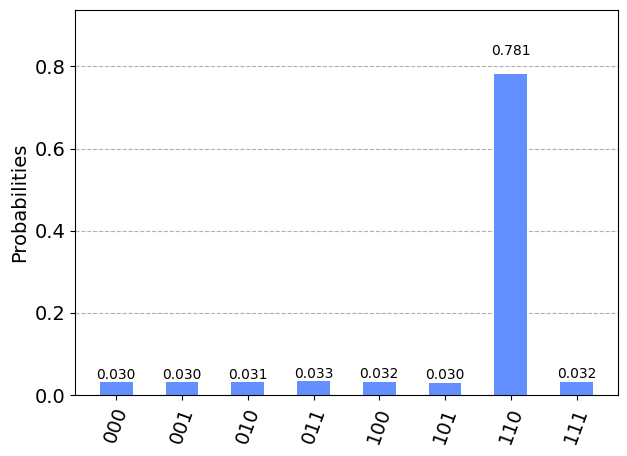

In [50]:
#  Histogram of measured states after one try
plot_histogram(counts1)

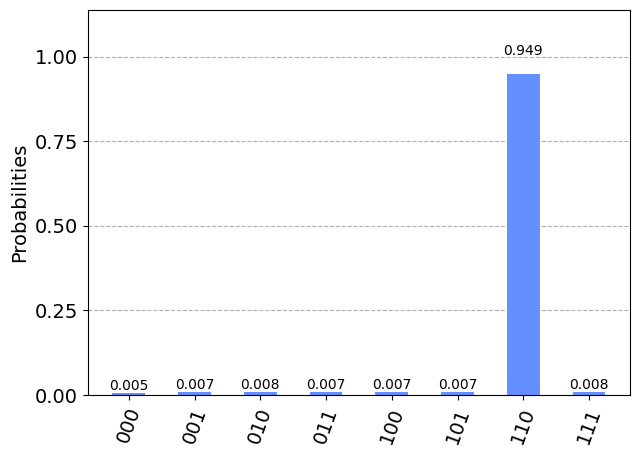

In [51]:
# Histogram of measured states after two tries
plot_histogram(counts2)

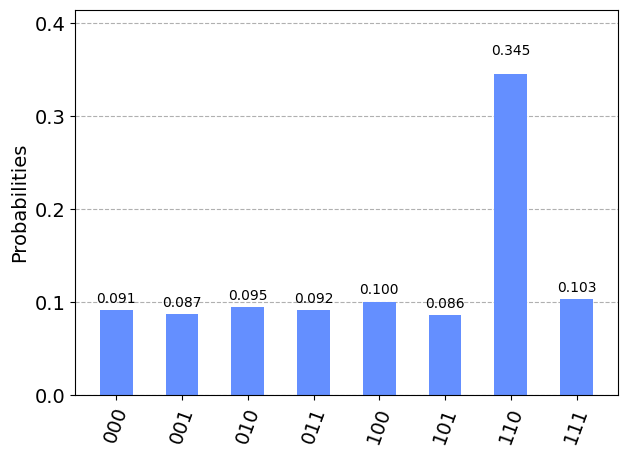

In [52]:
# Histogram of measured states after three tries
plot_histogram(counts3)

<span style="color:red;"> need to change </span>

### Discussion of the result
The first try already shows an astonishing result: that the desired state is most probable out of all the states in the database, with a probability of 26.8%. On average classically, one would have to try two times to ensure 25% of getting the item. With just one query we managed to get >25% with the Grover search.

The second try shows a slightly better result: that the desired state is 35.3% likely to be chosen out of all other states.

The third try shows a weird occurence. The desired state is 15.5% likely. This is a result of the amplitude flipping the entire state about its average. We thought $3$ times was appropriate for the search because the $\sqrt{8} \approx 3$, but truthfully, due to the nature of the algorithm, going *one less* than the root of the number of tries, if the tries are not integer, is best protocol. With a couple of shots, one can distinguish the desired result easily, as shown in the histogram plots. Despite that, we wish the result was even clearer with these small number of items and qubits.

The good news is, that classically, we search for such small databases and not see much of a disadvantage. The true interest is in cases where the database could range in the millions, billions, or even trillions of items to search through. An example of this is in protein and molecule conformations which, based on Levinthal's paradox, are computationally expensive search through, and the protein itself "knows instantly" what its lowest energy states (lower energy is more desirable in this example). We hope that in time the exploration of larger and larger datasets, proves the point even more that the quantum search is a more efficient search method than the classical version. 

## Using real quantum hardware to test Grover's search

Here we try our circuits using the IBMQ QASM simulator (essentially the same as the BasicAer simulator used above), and two real quantum hardware systems.

The real quantum hardware systems are named **ibmq_manila** and **ibmq_quito**, each having 5 qubits, and each with their own optimal gate configurations and characteristic errors. Each system has 5 qubits, the number of qubits needed for our Grover search.

In [53]:
# provider = IBMQ.load_account()

# backend_qassim = provider.get_backend("ibmq_qasm_simulator")
# backend_manila = provider.get_backend("ibmq_manila")
# # backend_oslo = provider.get_backend("ibmq_oslo")
# backend_quito = provider.get_backend("ibmq_quito")

ibmqfactory.load_account:WARNING:2022-11-15 03:51:47,748: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# # IBMQ QASM Simulator
# qc_1_tr_qassim = transpile(qc_1, backend_qassim)
# qc_2_tr_qassim = transpile(qc_2, backend_qassim)
# qc_3_tr_qassim = transpile(qc_3, backend_qassim)

In [ ]:
# # IBMQ Manila
# qc_1_tr_manila = transpile(qc_1, backend_manila)
# qc_2_tr_manila = transpile(qc_2, backend_manila)
# qc_3_tr_manila = transpile(qc_3, backend_manila)

In [ ]:
# # IBMQ Quito
# qc_1_tr_quito = transpile(qc_1, backend_quito)
# qc_2_tr_quito = transpile(qc_2, backend_quito)
# qc_3_tr_quito = transpile(qc_3, backend_quito)

In [57]:
# Sending Jobs
# job_qassim = backend_qassim.run(circuits=[qc_1_tr_qassim,qc_2_tr_qassim,qc_3_tr_qassim], job_name="QASM Simulator 3-Qubit Grover", shots=4000)
# job_manila = backend_manila.run(circuits=[qc_1_tr_manila,qc_2_tr_manila,qc_3_tr_manila], job_name="IBM Manila 3-Qubit Grover", shots=4000)
# job_quito = backend_quito.run(circuits=[qc_1_tr_quito,qc_2_tr_quito,qc_3_tr_quito], job_name="IBM Quito 3-Qubit Grover", shots=4000)

In [79]:
# Data from real quantum systems runs
qassim_counts_1 = {'000': 124, '001': 104, '010': 121, '011': 105, '100': 130, '101': 134, '110': 3155, '111': 127}
qassim_counts_2 = {'000': 33, '001': 33, '010': 29, '011': 28, '100': 31, '101': 40, '110': 3781, '111': 25}
qassim_counts_3 = {'000': 383, '001': 366, '010': 387, '011': 363, '100': 369, '101': 368, '110': 1371, '111': 393}
qassim_counts = [qassim_counts_1,qassim_counts_2,qassim_counts_3]

quito_counts_1 = {'000': 461, '001': 427, '010': 498, '011': 449, '100': 487, '101': 468, '110': 751, '111': 459}
quito_counts_2 = {'000': 461, '001': 533, '010': 462, '011': 467, '100': 489, '101': 461, '110': 613, '111': 514}
quito_counts_3 = {'000': 473, '001': 538, '010': 445, '011': 483, '100': 503, '101': 529, '110': 512, '111': 517}
quito_counts = [quito_counts_1,quito_counts_2,quito_counts_3]

manila_counts_1 = {'000': 462, '001': 468, '010': 585, '011': 521, '100': 463, '101': 458, '110': 555, '111': 488}
manila_counts_2 = {'000': 542, '001': 526, '010': 537, '011': 500, '100': 475, '101': 494, '110': 462, '111': 464}
manila_counts_3 = {'000': 486, '001': 578, '010': 499, '011': 479, '100': 525, '101': 516, '110': 457, '111': 460}
manila_counts = [manila_counts_1,manila_counts_2,manila_counts_3]

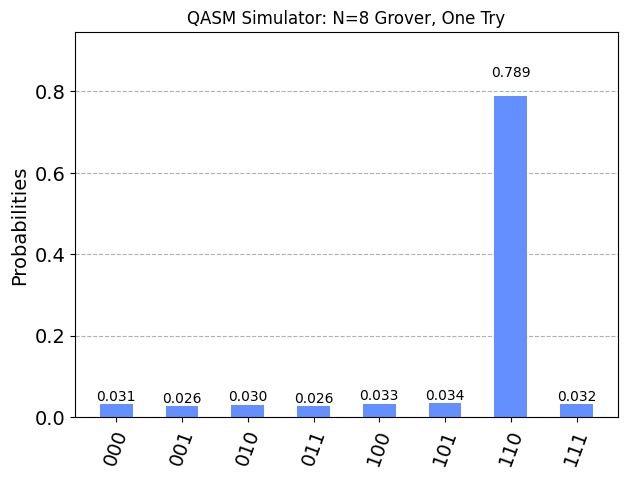

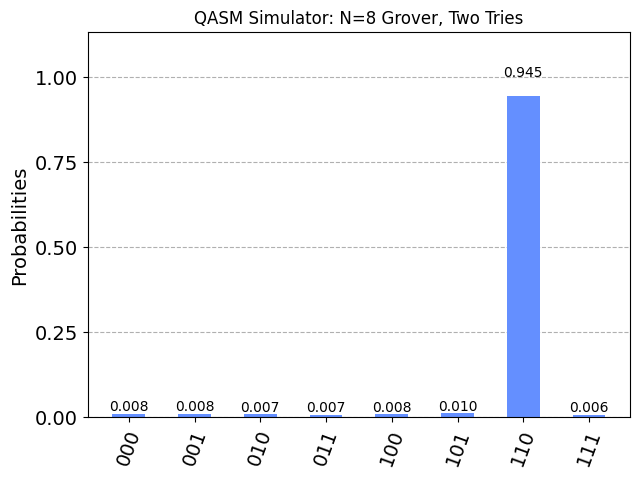

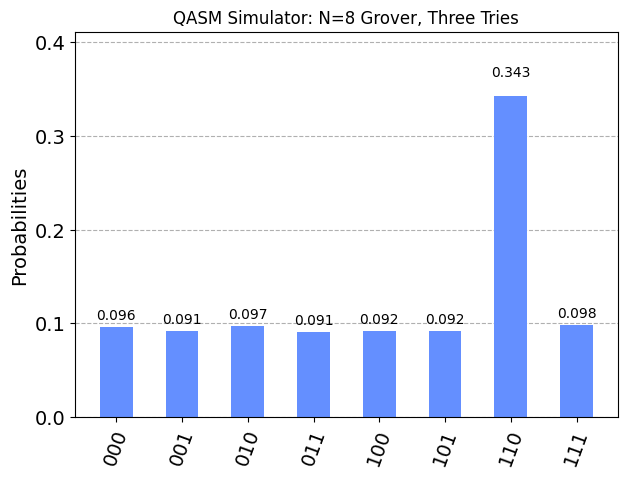

In [83]:
# Qassim Plots
qassim_plot_1 = plot_histogram(qassim_counts[0], title="QASM Simulator: N=8 Grover, One Try")
qassim_plot_2 = plot_histogram(qassim_counts[1], title="QASM Simulator: N=8 Grover, Two Tries")
qassim_plot_3 = plot_histogram(qassim_counts[2], title="QASM Simulator: N=8 Grover, Three Tries")

display(qassim_plot_1,qassim_plot_2,qassim_plot_3)

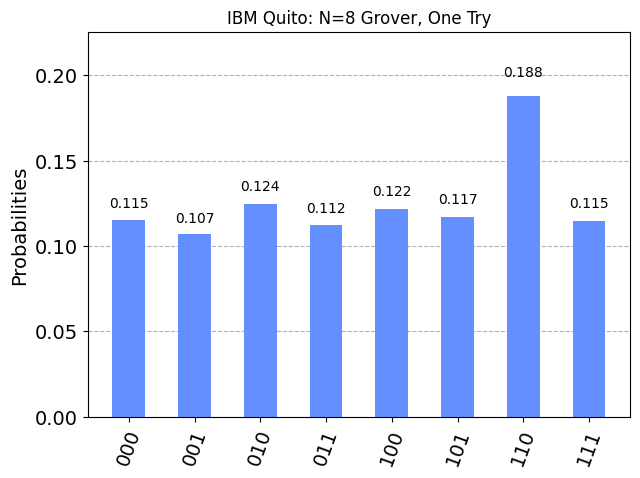

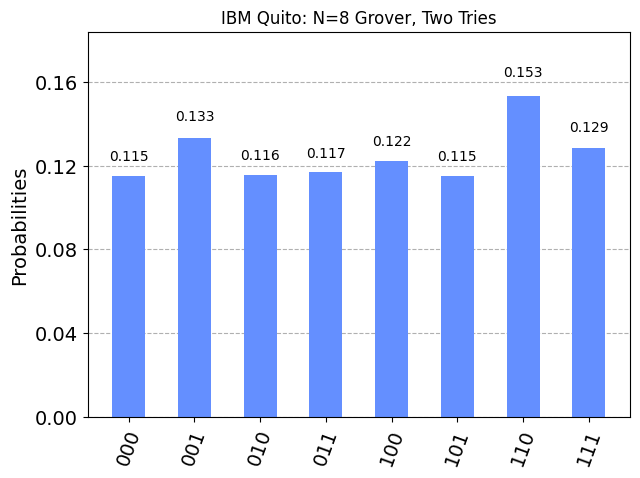

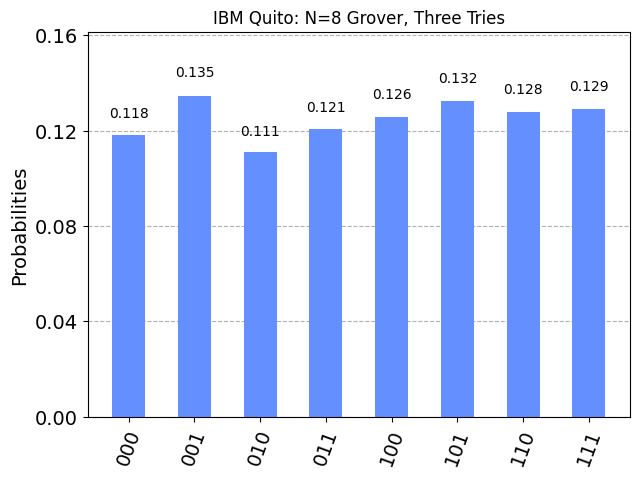

In [81]:
# Quito Plots
quito_plot_1 = plot_histogram(quito_counts[0], title="IBM Quito: N=8 Grover, One Try")
quito_plot_2 = plot_histogram(quito_counts[1], title="IBM Quito: N=8 Grover, Two Tries")
quito_plot_3 = plot_histogram(quito_counts[2], title="IBM Quito: N=8 Grover, Three Tries")

display(quito_plot_1,quito_plot_2,quito_plot_3)

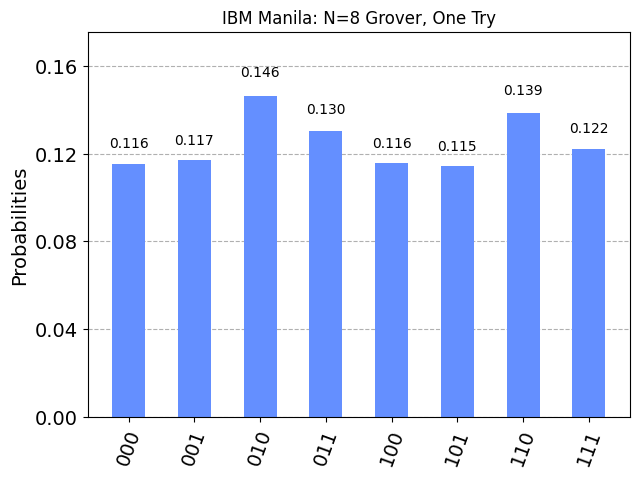

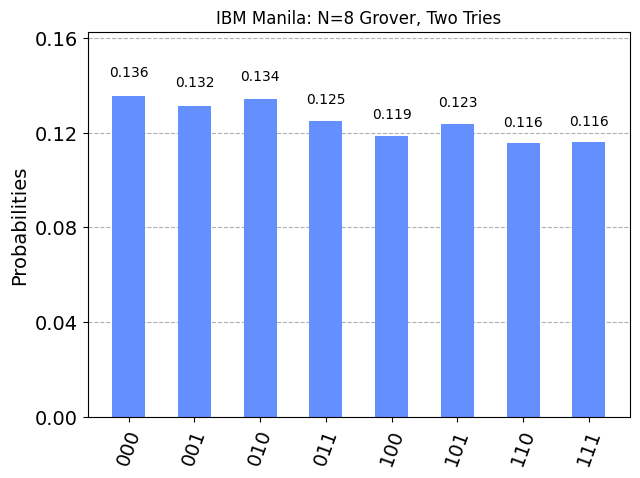

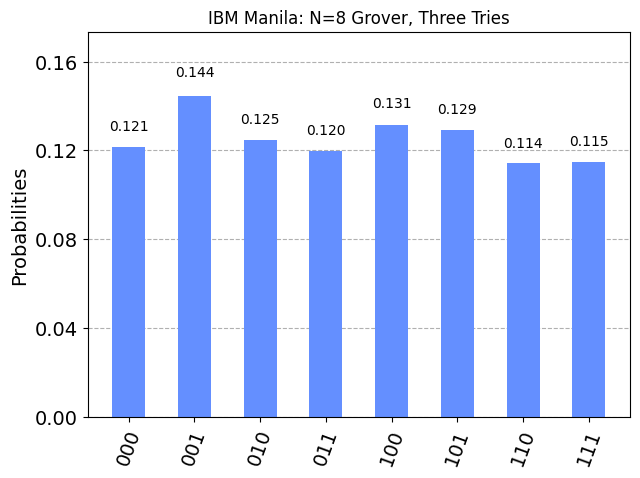

In [82]:
# Manila Plots
manila_plot_1 = plot_histogram(manila_counts[0], title="IBM Manila: N=8 Grover, One Try")
manila_plot_2 = plot_histogram(manila_counts[1], title="IBM Manila: N=8 Grover, Two Tries")
manila_plot_3 = plot_histogram(manila_counts[2], title="IBM Manila: N=8 Grover, Three Tries")

display(manila_plot_1,manila_plot_2,manila_plot_3)

<span style="color:red;"> need to change </span>

### Results of the Quito 3 Qubit Grover Search
At the time of writing (October 30, 2021, 11:53 am) the results of the Quito Grover search provided some interesting results. 

Though it's disappointing that the probability of the desired item wasn't amplified on the second try of the search, the probability of finding the item after one try was $16.5\%$, still greater than the classical limit $1/8=12.5\%$. This shows that even with a single try on a real, error-prone system, there is still some quantum "advantage" being revealed. 

The free backends provided by IBMQ may not represent the best hardware for quantum tests. We suspect that substantial errors, especially from a higher-depth circuit like the second and third tries of the Grover search would amplify such errors and cause the results as shown. 

Regardless, we warrant such tests for the minute advantages seen in the case of the single try of the Grover search, as they provide some evidence of a quantum "advantage" that could be studied in greater detail on higher fidelity systems.